In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import data
import numpy as np
import yfinance as yf
from datetime import date, timedelta, time

In [3]:
symbol = "ROSSELLIND.NS"
start_time = date.today() - timedelta(days=40)
end_time = date.today()

In [4]:
fivemin = yf.download(symbol, interval='15m', start=start_time, end=end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [5]:
daily_start_time = date.today() - timedelta(days=200)
daily_end_time = date.today()
daily = yf.download(symbol, start=daily_start_time, end=daily_end_time, index_col=0, parse_dates=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
import ta
daily['rsi'] = ta.momentum.rsi(daily['Adj Close'])

In [7]:
df = fivemin

In [8]:
# fivemin
df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-03-17 09:15:00+05:30,164.800003,164.800003,159.699997,162.199997,162.199997,7833
2022-03-17 09:30:00+05:30,162.199997,162.199997,160.199997,161.600006,161.600006,7784
2022-03-17 09:45:00+05:30,161.600006,161.600006,159.949997,159.949997,159.949997,4673
2022-03-17 10:00:00+05:30,159.949997,160.000000,159.000000,159.550003,159.550003,1871
2022-03-17 10:15:00+05:30,159.250000,159.449997,158.449997,158.500000,158.500000,1120


In [9]:
df['5ema'] = df['Close'].rolling(5).mean()

In [10]:
df = df.dropna()

In [11]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,5ema
Datetime,,,,,,,
2022-04-25 14:15:00+05:30,206.050003,206.649994,206.000000,206.000000,206.000000,3351,206.289999
2022-04-25 14:30:00+05:30,206.000000,206.300003,206.000000,206.149994,206.149994,2317,206.149997
2022-04-25 14:45:00+05:30,206.449997,207.250000,206.000000,207.000000,207.000000,2455,206.349997
2022-04-25 15:00:00+05:30,206.949997,207.000000,206.149994,206.600006,206.600006,2741,206.429999
2022-04-25 15:15:00+05:30,206.550003,207.800003,205.100006,206.649994,206.649994,8185,206.479999


In [12]:
from datetime import datetime
# add previous day rsi to each row in the df
shifted_daily_rsi = daily['rsi'].shift(1)

df['prev_daily_rsi'] = np.nan
for daily_idx in shifted_daily_rsi.index:
    for df_idx in df.index:
        if df_idx.date() == daily_idx.date():
            df['prev_daily_rsi'] = shifted_daily_rsi[daily_idx]


/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [13]:
# entry candle is the one which is above 5 ema and doesnt touch 5ema line.
df['entry_candle'] = np.nan
# now we need to look for a candle which crosses the entry candle low, that will be the buy price.
df['signal'] = np.nan
df['buy_price'] = np.nan
df['sell_price'] = np.nan

entry_candle_index = -1
in_trade = False
length_of_signal_candle = -1
buy_price = -1

for idx in df.index:
    
    if not in_trade:
        
        # now we have found the entry candle 
        # we are looking for a entry in a trade now.
        # as soon as the candle crosses the low of entry_candle, we enter the trade.
        if entry_candle_index != -1:
            
            # do not enter the trade after 3:15PM
            if idx.time() >= time(hour=15, minute=15):
                entry_candle_index = -1
                continue
                
            # do not enter again if the price is below 5ema again, start again.
            if df['5ema'][idx] > df['Low'][entry_candle_index]:
                entry_candle_index = -1
                continue

            if df['Low'][idx] < df['Low'][entry_candle_index]:
                df['signal'][idx] = 1
                length_of_signal_candle = df['High'][entry_candle_index] - df['Low'][entry_candle_index]
                buy_price = df['Low'][entry_candle_index]
                df['buy_price'][idx] = df['Low'][entry_candle_index]
                in_trade = True

                
        # this is a trigger condition, it sets the entry_candle_idx which then our algo uses of 
        # to enter the trade.
        
        # we are not in a trade.
        # check when the candle gets created above the 5ema line.
        # this will update the entry-candle index to the next candle if the condition still meets.
        
        # dont make an entry if the rsi on the daily candle of the previous day is below 30
        # only when the daily rsi is greater than 40, think about shorting else skip
        if df['5ema'][idx] < df['Low'][idx] and df['prev_daily_rsi'][idx] > 60: 
            entry_candle_index = idx

    else:
        # if we are in a trade
        # either we hit SL
        if df['High'][idx] >= buy_price + length_of_signal_candle:
            # we are closing the trade at closing price of the candle
            # df['sell_price'][idx] = df['Close'][idx] # buy_price + length_of_signal_candle -> when SL is touched...
            
            # close the price as soon as the SL is hit
            df['sell_price'][idx] = buy_price + length_of_signal_candle
            
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            buy_price = -1
            entry_candle_index = -1
            in_trade = False
            
        # or we hit the target.
        # currently the strategy exits the position when 1:2 trade is reached.
        elif df['Low'][idx] <= buy_price - 2 * length_of_signal_candle:
            # uncomment the below line to exit at the close of candle which touches the target.
#             df['sell_price'][idx] = df['Close'][idx] # buy_price - 2 * length_of_signal_candle  -> same as above
            df['sell_price'][idx] = buy_price - 2 * length_of_signal_candle
    
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            entry_candle_index = -1
            buy_price = -1
            in_trade = False
            
        # exit from the strategy if the day has ended @3:!5
        elif idx.time() == time(hour=15, minute=25):
            df['sell_price'][idx] = df['Close'][idx]
            
            # set variables to close the trade.
            df['signal'][idx] = -1
            length_of_signal_candle = -1
            entry_candle_index = -1
            buy_price = -1
            in_trade = False
        

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_95384/3250832313.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][idx] = 1
/var/folders/1r/4l552nf17t77rvcg5njtz4540000gn/T/ipykernel_95384/3250832313.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [14]:
tradesdf = df[(df.signal == 1) | (df.signal == -1)]
tradesdf.tail(10)

,Open,High,Low,Close,Adj Close,Volume,5ema,prev_daily_rsi,entry_candle,signal,buy_price,sell_price
Datetime,,,,,,,,,,,,
2022-04-19 13:00:00+05:30,191.149994,191.350006,190.649994,190.649994,190.649994,366,190.900000,67.133673,NaN,1.0,191.000000,NaN
2022-04-19 15:15:00+05:30,190.149994,190.250000,183.600006,184.000000,184.000000,18641,189.180002,67.133673,NaN,-1.0,NaN,188.700012
2022-04-20 09:45:00+05:30,190.699997,191.000000,190.000000,190.649994,190.649994,3690,189.239999,67.133673,NaN,1.0,190.449997,NaN
2022-04-20 11:00:00+05:30,190.000000,190.500000,188.300003,190.300003,190.300003,14107,190.160004,67.133673,NaN,-1.0,NaN,188.849991
2022-04-20 11:30:00+05:30,190.300003,190.300003,189.850006,189.850006,189.850006,2934,190.110004,67.133673,NaN,1.0,190.300003,NaN
2022-04-20 11:45:00+05:30,189.000000,189.000000,188.500000,188.500000,188.500000,1027,189.810004,67.133673,NaN,-1.0,NaN,190.300003
2022-04-25 11:00:00+05:30,209.250000,209.500000,208.399994,209.050003,209.050003,815,208.760001,67.133673,NaN,1.0,209.600006,NaN
2022-04-25 12:15:00+05:30,207.000000,207.000000,205.500000,206.000000,206.000000,3697,207.270001,67.133673,NaN,-1.0,NaN,206.000031
2022-04-25 14:15:00+05:30,206.050003,206.649994,206.000000,206.000000,206.000000,3351,206.289999,67.133673,NaN,1.0,206.399994,NaN


In [15]:
# because this is a shorting trade.
tradesdf['pnl'] = tradesdf.buy_price.shift(1) - tradesdf.sell_price

/Users/prince/miniconda3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [16]:
total_trades = len(tradesdf.pnl.dropna())
total_trades

29

In [17]:
winning_trades = tradesdf[tradesdf.pnl > 0]
loosing_trades = tradesdf[tradesdf.pnl <= 0]
winning_prob = len(winning_trades) / total_trades
winning_prob

0.1724137931034483

In [18]:
avg_winning_trade_pnl = winning_trades.pnl.sum() / len(winning_trades)
print(avg_winning_trade_pnl)
avg_loosing_trade_pnl = loosing_trades.pnl.sum() / len(loosing_trades)
print(avg_loosing_trade_pnl)

3.9199951171875
-1.0312493642171223


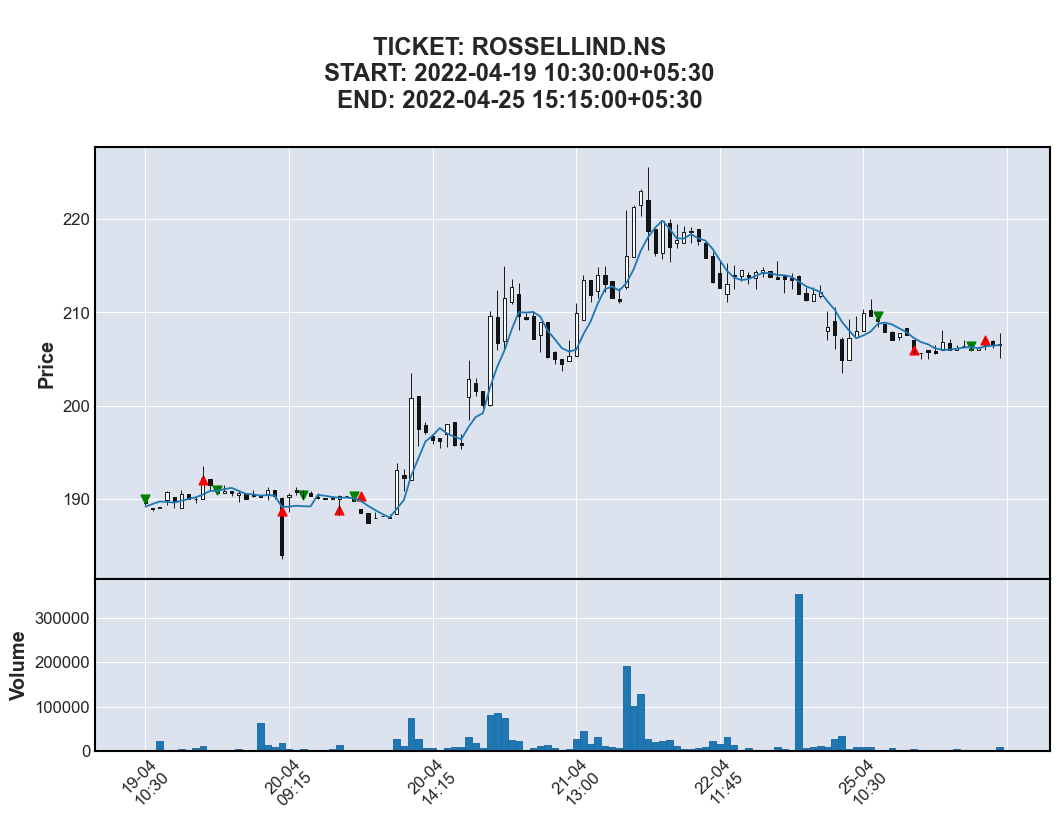

In [19]:
import mplfinance as mpf

def plot(df):
    # 14:45 corresponds to 9:15 in IST timezone
#     vline = df[df.index.map(lambda x: x.time()) == time(hour=14, minute=45)].index
#     vline = df[df.index.map(lambda x: x.time()) == time(hour=14, minute=50)].index
#     print(vline.values)
    apds = [
        mpf.make_addplot(df['5ema']),
#         mpf.make_addplot(df['signal'] ,type='scatter', markersize=100, marker='v'),
        mpf.make_addplot(df['buy_price'], type='scatter', markersize=40, marker='v', color='g'),
        mpf.make_addplot(df['sell_price'] ,type='scatter', markersize=40, marker='^', color='r')
    ]
    
    mpf.plot(df, volume=True, type='candle', 
#              vlines=dict(vlines=vline.values),
             addplot=apds, figratio=(20,13), figscale=1.5, 
            title='\nTICKET: %s\nSTART: %s\nEND: %s' % (symbol, df.index[0], df.index[-1]), 
             datetime_format='%d-%m\n%H:%M')
    
    

plot(df.tail(120))